Importing libraries

In [1]:
!echo !pip install matplotlib

!pip install matplotlib


In [78]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time

Creating data parser

In [79]:
DATABASE_URL = "https://crossoutdb.com/"

def getJSONDataOfItemByID(fileID: int):
    id = fileID
    path = 'data/item/all/'
    url = DATABASE_URL + path + str(id)
    requests_file = requests.get(url)
    jsonData = requests_file.json()['Data']
    return jsonData

JSONdataOfItemWithID_68 = getJSONDataOfItemByID(68)

In [80]:
def convertOneItemDataToDataframeFromJson(jsonData):
    jsonDataCopy_1 = jsonData
    
    def getArrayDataFromJson(jsonData):
        jsonDataCopy = jsonData
        
        numberOfColumns = len(jsonDataCopy)
        numberOfRows = len(jsonDataCopy[0])

        # json file has shape of 4 "columns" with the same lenght. 
        # Each column is represented by time (like key) and its value.

        arrayData = []
        for row in range(numberOfRows):
            sellPrice = jsonDataCopy[0][row][1]
            buyPrice = jsonDataCopy[1][row][1]
            sellOffers = jsonDataCopy[2][row][1]
            buyOrders = jsonDataCopy[3][row][1]

            # key / time --- UNIX_TIMESTAMP
            dateTime = jsonDataCopy[0][row][0]

            rowData = [dateTime, sellPrice, buyPrice, sellOffers, buyOrders]
            arrayData.append(rowData)
        return arrayData
    
    numpyArrayData = np.array(getArrayDataFromJson(jsonDataCopy_1))
    df = pd.DataFrame(numpyArrayData, columns=["Date Time", "Sell Price", "Buy Price", "Sell Offers", "Buy Orders"])
    return df

In [81]:
data_df = convertOneItemDataToDataframeFromJson(JSONdataOfItemWithID_68)
print(data_df.head())

      Date Time  Sell Price  Buy Price  Sell Offers  Buy Orders
0  1.711112e+12       36.70      30.34         69.0        39.0
1  1.711116e+12       35.00      30.22         84.0        34.0
2  1.711120e+12       35.54      30.22         86.0        32.0
3  1.711123e+12       35.71      30.20         86.0        27.0
4  1.711127e+12       35.70      30.61         77.0        27.0


Creating plot form data

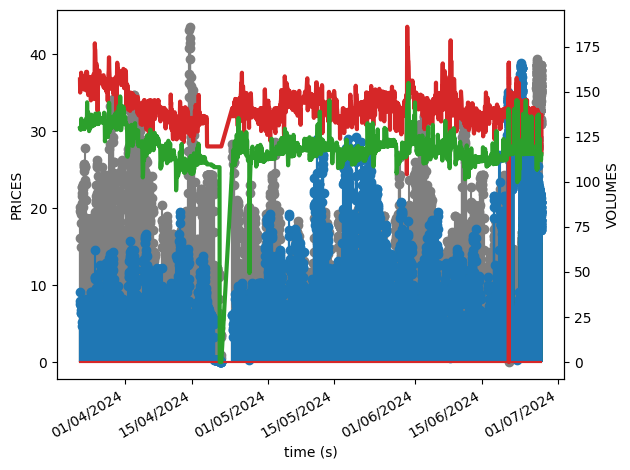

In [96]:
import matplotlib.dates as mdates

def plotData(data: pd.core.frame.DataFrame):
    dateTime = data["Date Time"]
    sellPrice = data["Sell Price"]
    buyPrice = data["Buy Price"]
    sellOffers = data["Sell Offers"]
    buyOrders = data["Buy Orders"]
    
    def formatData(data):
        floatData = data.apply(lambda x: float(x))
        dataArray = floatData.to_numpy()
        return dataArray
    
    dateTime = pd.to_datetime(dateTime, unit='ms')
    sellPrice = formatData(sellPrice)
    buyPrice = formatData(buyPrice)
    sellOffers = formatData(sellOffers)
    buyOrders = formatData(buyOrders)
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('PRICES')
    ax1.plot(dateTime, sellPrice, color='tab:red', linewidth=3)
    ax1.plot(dateTime, buyPrice, color='tab:green', linewidth=3)
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('VOLUMES')  # we already handled the x-label with ax1
    ax2.stem(dateTime, sellOffers, linefmt='tab:grey')
    ax2.stem(dateTime, buyOrders, linefmt='tab:blue')
    ax2.tick_params(axis='y')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    fig.autofmt_xdate()  # Rotation of date labels

    ax1.set_zorder(2)
    ax2.set_zorder(1)
    ax1.patch.set_visible(False)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
plotData(data_df)

Market history is too large. We will operrate on last week history. So lets create a trim function

In [97]:
from datetime import timedelta

def trimDataFromTheLastWeek(data: pd.core.frame.DataFrame):
    WEEK_SECONDS = 604800
    
    dataCopy = data.copy()
    
    dataCopy['Temp Date Time'] = pd.to_datetime(dataCopy['Date Time'], unit='ms')

    lastTimestamp = dataCopy['Temp Date Time'].iloc[-1]
    
    oneWeekAgo = lastTimestamp  - timedelta(weeks=1)
    
    dfLastWeek = dataCopy[dataCopy['Temp Date Time'] >= oneWeekAgo]
    
    dfLastWeek = dfLastWeek.drop(columns=['Temp Date Time'])
    
    return dfLastWeek

lastWeek = trimDataFromTheLastWeek(data_df)
print(lastWeek)

         Date Time  Sell Price  Buy Price  Sell Offers  Buy Orders
2106  1.718886e+12       32.97      27.09         47.0       146.0
2107  1.718886e+12       32.97      28.00         47.0       147.0
2108  1.718886e+12       32.97      28.00         47.0       147.0
2109  1.718887e+12       32.97      28.00         47.0       147.0
2110  1.718887e+12       32.97      27.09         47.0       146.0
...            ...         ...        ...          ...         ...
4070  1.719489e+12       32.09      27.00        132.0        89.0
4071  1.719489e+12       31.66      27.00        134.0        89.0
4072  1.719490e+12       32.00      27.00        133.0        88.0
4073  1.719490e+12       31.99      27.00        134.0        86.0
4074  1.719490e+12       31.99      27.00        135.0        86.0

[1969 rows x 5 columns]


##Now we can look at plot

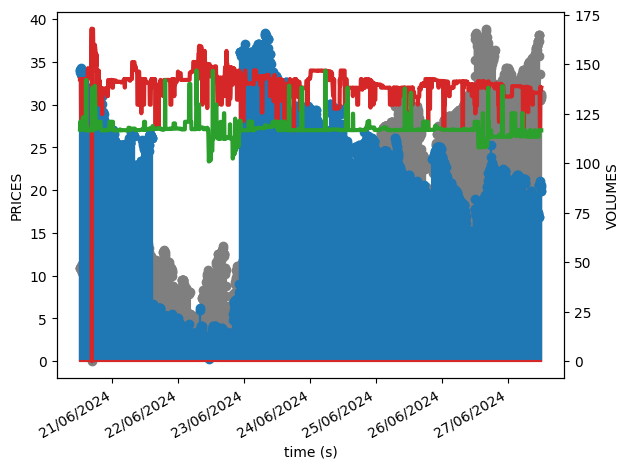

In [99]:
plotData(lastWeek)